In [1]:
# Constants for you to change
import os

DATA_DIRECTORY = '/home/younes'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'wiki-Talk.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/wiki-Talk.txt.gz'

# Just have these hardcoded, though we don't really need to
NUM_EDGES = 5021410
NUM_NODES = 2394385

In [2]:
# Downloading the file

import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
if not os.path.exists(LIVEJOURNAL_FILENAME):
    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30

DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE

FILE STATS:
-rw-rw-r-- 1 younes younes 17M ماي 19 04:05 /home/younes/wiki-Talk.txt.gz

STARTING LINES
# Directed graph (each unordered pair of nodes is saved once): WikiTalk.txt 
# Communication network of Wikipedia (till January 2008). Directed edge A->B means user A edited talk page of B.
# Nodes: 2394385 Edges: 5021410
# FromNodeId	ToNodeId
0	1
2	1
2	21
2	46
2	63
2	88
2	93
2	94
2	101
2	102
2	103
2	116
2	119
2	125
2	130
2	142
2	146
2	150
2	155
2	156
2	165
2	168
2	212
2	288
2	308
2	313

gzip: stdout: Broken pipe


In [3]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line.split('\t')
                yield(int(left_node), int(right_node))

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-talk.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-talked.npy')

    if os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges = to_undirected(row_generator(), NUM_EDGES, NUM_NODES, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges

In [4]:
print("Normalizing data (or loaded pre-computed)")
%time edges = get_clean_data(shuffle=True)
%time unshuffled_edges = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Loading from file /home/younes/LJ-talk.npy
CPU times: user 12.5 ms, sys: 43.5 ms, total: 56 ms
Wall time: 1.35 s
Loading from file /home/younes/LJ-talked.npy
CPU times: user 5.7 ms, sys: 66.3 ms, total: 72 ms
Wall time: 1.19 s

EDGES SHAPE: (9319130, 2)


In [5]:
def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [6]:
%load_ext cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [8]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 2, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 270 ms, sys: 3.92 ms, total: 274 ms
Wall time: 273 ms
edge score:0.40313054974015816 waste: 4.17643779115906e-07


In [9]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 4, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 314 ms, sys: 778 µs, total: 315 ms
Wall time: 313 ms
edge score:0.5923454228023431 waste: 1.252931337347718e-06


In [10]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 8, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 332 ms, sys: 81 µs, total: 332 ms
Wall time: 330 ms
edge score:0.697712340100417 waste: 2.923506453617053e-06


In [11]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 16, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 370 ms
edge score:0.7368808032509473 waste: 6.264656686322256e-06


In [12]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 32, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 461 ms, sys: 78 µs, total: 461 ms
Wall time: 459 ms
edge score:0.7641339910485206 waste: 0.0002067336706503553


In [13]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 40, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 515 ms, sys: 313 µs, total: 515 ms
Wall time: 513 ms
edge score:0.7751343741314908 waste: 0.00039049693345052927


In [14]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Edge cut')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [15]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, NUM_NODES, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)


2 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.403
1	0.000	0.274
2	0.000	0.271
3	0.000	0.216
4	0.000	0.234
5	0.000	0.222
6	0.000	0.226
7	0.000	0.223
8	0.000	0.225
9	0.000	0.223
10	0.000	0.227
11	0.000	0.223
12	0.000	0.225
13	0.000	0.223
14	0.000	0.227
15	0.000	0.223
16	0.000	0.225
17	0.000	0.223
18	0.000	0.227
19	0.000	0.223
CPU times: user 10.3 s, sys: 1.38 s, total: 11.7 s
Wall time: 11.5 s


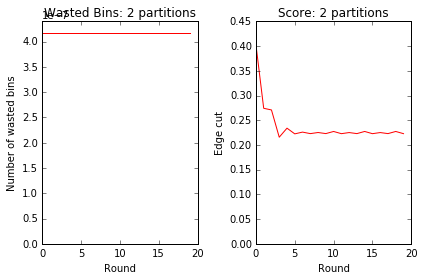

In [16]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=2, num_iterations=20)



4 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.592
1	0.000	0.465
2	0.000	0.420
3	0.000	0.380
4	0.000	0.362
5	0.000	0.341
6	0.000	0.324
7	0.000	0.351
8	0.000	0.357
9	0.000	0.375
10	0.000	0.330
11	0.000	0.330
12	0.000	0.337
13	0.000	0.345
14	0.000	0.347
15	0.000	0.362
16	0.000	0.397
17	0.000	0.422
18	0.000	0.382
19	0.000	0.390
CPU times: user 10.6 s, sys: 1.47 s, total: 12 s
Wall time: 11.8 s


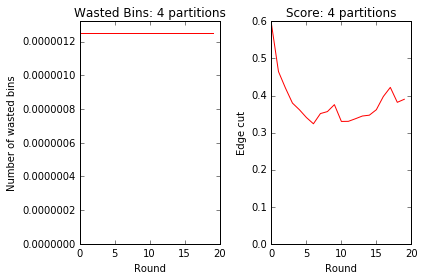

In [17]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=4, num_iterations=20)



8 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.698
1	0.000	0.544
2	0.000	0.532
3	0.000	0.483
4	0.000	0.504
5	0.000	0.526
6	0.000	0.517
7	0.000	0.518
8	0.000	0.516
9	0.000	0.517
10	0.000	0.516
11	0.000	0.517
12	0.000	0.516
13	0.000	0.517
14	0.000	0.516
15	0.000	0.517
16	0.000	0.516
17	0.000	0.517
18	0.000	0.516
19	0.000	0.517
CPU times: user 11.2 s, sys: 1.36 s, total: 12.6 s
Wall time: 12.3 s


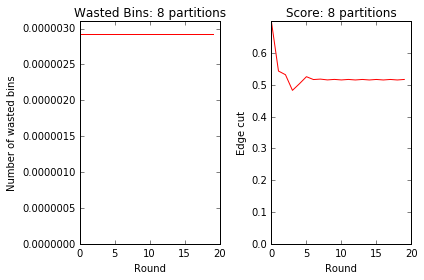

In [18]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=8, num_iterations=20)



16 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.737
1	0.000	0.588
2	0.000	0.534
3	0.000	0.519
4	0.000	0.503
5	0.000	0.512
6	0.000	0.501
7	0.000	0.505
8	0.000	0.506
9	0.000	0.505
10	0.000	0.506
11	0.000	0.505
12	0.000	0.506
13	0.000	0.504
14	0.000	0.506
15	0.000	0.504
16	0.000	0.506
17	0.000	0.504
18	0.000	0.506
19	0.000	0.504
CPU times: user 12.2 s, sys: 1.35 s, total: 13.6 s
Wall time: 13.4 s


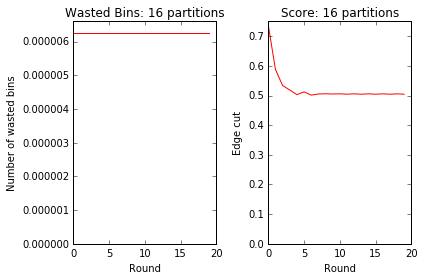

In [19]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=16, num_iterations=20)



32 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.764
1	0.000	0.595
2	0.000	0.550
3	0.000	0.534
4	0.000	0.536
5	0.000	0.533
6	0.000	0.533
7	0.000	0.540
8	0.000	0.531
9	0.000	0.538
10	0.000	0.530
11	0.000	0.537
12	0.000	0.530
13	0.000	0.537
14	0.000	0.530
15	0.000	0.537
16	0.000	0.530
17	0.000	0.537
18	0.000	0.530
19	0.000	0.537
CPU times: user 14.6 s, sys: 1.54 s, total: 16.1 s
Wall time: 21.6 s


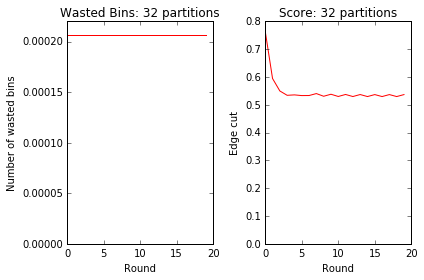

In [20]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=32, num_iterations=20)



40 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.775
1	0.000	0.592
2	0.000	0.564
3	0.000	0.544
4	0.000	0.541
5	0.000	0.542
6	0.000	0.538
7	0.000	0.538
8	0.000	0.537
9	0.000	0.538
10	0.000	0.536
11	0.000	0.538
12	0.000	0.536
13	0.000	0.538
14	0.000	0.536
15	0.000	0.538
16	0.000	0.536
17	0.000	0.538
18	0.000	0.536
19	0.000	0.538
CPU times: user 16.3 s, sys: 1.42 s, total: 17.7 s
Wall time: 17.4 s


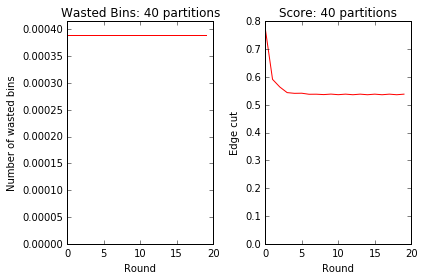

In [21]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=40, num_iterations=20)


In [22]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [25]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 417 ms, sys: 218 µs, total: 417 ms
Wall time: 417 ms
wast=1.0000004176437791 edge cut = 0.3287442068090047


In [26]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 453 ms, sys: 199 µs, total: 453 ms
Wall time: 465 ms
wast=1.0000029235064536 edge cut = 0.5011600868321399


In [27]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 477 ms, sys: 3.67 ms, total: 480 ms
Wall time: 489 ms
wast=1.0000029235064536 edge cut = 0.5739200976915227


In [28]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,16,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 489 ms, sys: 3.68 ms, total: 492 ms
Wall time: 498 ms
wast=1.0000196292576173 edge cut = 0.6365624258916873


In [29]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,32,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 713 ms, sys: 280 µs, total: 714 ms
Wall time: 713 ms
wast=1.0000864522622719 edge cut = 0.6967116029071383


In [30]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,40,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 839 ms, sys: 549 µs, total: 840 ms
Wall time: 844 ms
wast=1.000123204914832 edge cut = 0.7022185547363327


In [32]:
def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(1.251608191745264e-04, 7.588951557309824e-02, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, NUM_NODES, num_partitions, assignments, 1.)
        (waste, edge_score) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}'.format(i, alpha, waste, edge_score))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

# K = 2

2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.329
1	4.1e-06	0.000	0.215
2	8.1e-06	0.000	0.194
3	1.2e-05	0.000	0.186
4	1.6e-05	0.000	0.183
5	2.0e-05	0.000	0.181
6	2.4e-05	0.000	0.180
7	2.8e-05	0.000	0.180
8	3.2e-05	0.000	0.180
9	3.6e-05	0.000	0.180
10	4.0e-05	0.000	0.180
11	4.4e-05	0.000	0.180
12	4.8e-05	0.000	0.180
13	5.2e-05	0.000	0.180
14	5.6e-05	0.000	0.180
15	6.0e-05	0.000	0.180
16	6.4e-05	0.000	0.180
17	6.8e-05	0.000	0.180
18	7.2e-05	0.000	0.180
19	7.6e-05	0.000	0.180
CPU times: user 12.8 s, sys: 1.46 s, total: 14.2 s
Wall time: 14.1 s


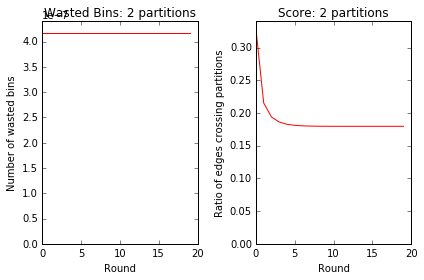

In [40]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.329
1	4.0e-03	0.000	0.215
2	8.0e-03	0.000	0.194
3	1.2e-02	0.000	0.186
4	1.6e-02	0.000	0.183
5	2.0e-02	0.000	0.181
6	2.4e-02	0.000	0.180
7	2.8e-02	0.000	0.180
8	3.2e-02	0.000	0.180
9	3.6e-02	0.000	0.180
10	4.0e-02	0.000	0.180
11	4.4e-02	0.000	0.180
12	4.8e-02	0.000	0.180
13	5.2e-02	0.000	0.180
14	5.6e-02	0.000	0.180
15	6.0e-02	0.000	0.180
16	6.4e-02	0.000	0.180
17	6.8e-02	0.000	0.180
18	7.2e-02	0.000	0.180
19	7.6e-02	0.000	0.180
CPU times: user 11.3 s, sys: 1.32 s, total: 12.6 s
Wall time: 12.4 s


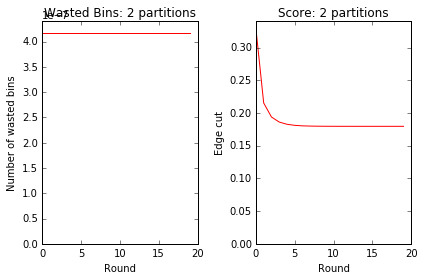

In [24]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


# k = 4

4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-04	0.000	0.501
1	4.1e-03	0.000	0.397
2	8.1e-03	0.000	0.384
3	1.2e-02	0.000	0.379
4	1.6e-02	0.000	0.376
5	2.0e-02	0.000	0.373
6	2.4e-02	0.000	0.371
7	2.8e-02	0.000	0.370
8	3.2e-02	0.000	0.370
9	3.6e-02	0.000	0.370
10	4.0e-02	0.000	0.369
11	4.4e-02	0.000	0.369
12	4.8e-02	0.000	0.369
13	5.2e-02	0.000	0.369
14	5.6e-02	0.000	0.369
15	6.0e-02	0.000	0.369
16	6.4e-02	0.000	0.369
17	6.8e-02	0.000	0.369
18	7.2e-02	0.000	0.369
19	7.6e-02	0.000	0.369
CPU times: user 11.4 s, sys: 1.22 s, total: 12.6 s
Wall time: 12.5 s


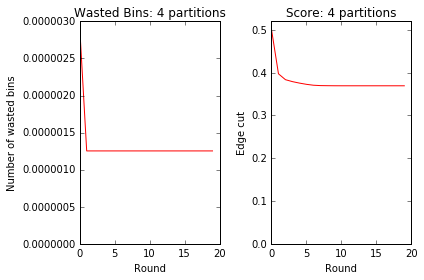

In [27]:
%time run_fennel_restreaming(edges, NUM_NODES, 4, 20)


8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.574
1	4.0e-03	0.000	0.469
2	8.0e-03	0.000	0.455
3	1.2e-02	0.000	0.450
4	1.6e-02	0.000	0.449
5	2.0e-02	0.000	0.448
6	2.4e-02	0.000	0.448
7	2.8e-02	0.000	0.448
8	3.2e-02	0.000	0.448
9	3.6e-02	0.000	0.448
10	4.0e-02	0.000	0.448
11	4.4e-02	0.000	0.448
12	4.8e-02	0.000	0.448
13	5.2e-02	0.000	0.448
14	5.6e-02	0.000	0.448
15	6.0e-02	0.000	0.448
16	6.4e-02	0.000	0.448
17	6.8e-02	0.000	0.448
18	7.2e-02	0.000	0.448
19	7.6e-02	0.000	0.448
CPU times: user 12.3 s, sys: 1.31 s, total: 13.6 s
Wall time: 13.4 s


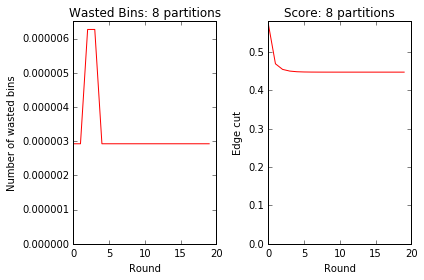

In [30]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 20)


16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-04	0.000	0.637
1	4.1e-03	0.000	0.573
2	8.1e-03	0.000	0.569
3	1.2e-02	0.000	0.567
4	1.6e-02	0.000	0.567
5	2.0e-02	0.000	0.566
6	2.4e-02	0.000	0.566
7	2.8e-02	0.000	0.566
8	3.2e-02	0.000	0.566
9	3.6e-02	0.000	0.566
10	4.0e-02	0.000	0.566
11	4.4e-02	0.000	0.566
12	4.8e-02	0.000	0.566
13	5.2e-02	0.000	0.566
14	5.6e-02	0.000	0.566
15	6.0e-02	0.000	0.566
16	6.4e-02	0.000	0.566
17	6.8e-02	0.000	0.566
18	7.2e-02	0.000	0.566
19	7.6e-02	0.000	0.566
CPU times: user 13.3 s, sys: 1.3 s, total: 14.6 s
Wall time: 14.4 s


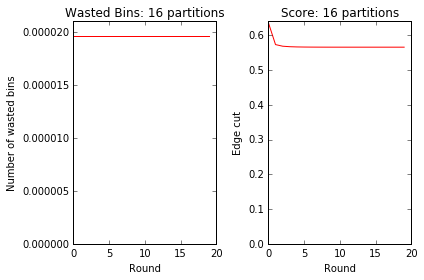

In [33]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-04	0.000	0.697
1	4.1e-03	0.000	0.636
2	8.1e-03	0.000	0.631
3	1.2e-02	0.000	0.630
4	1.6e-02	0.000	0.630
5	2.0e-02	0.000	0.629
6	2.4e-02	0.000	0.629
7	2.8e-02	0.000	0.629
8	3.2e-02	0.000	0.629
9	3.6e-02	0.000	0.629
10	4.0e-02	0.000	0.629
11	4.4e-02	0.000	0.629
12	4.8e-02	0.000	0.629
13	5.2e-02	0.000	0.629
14	5.6e-02	0.000	0.629
15	6.0e-02	0.000	0.629
16	6.4e-02	0.000	0.629
17	6.8e-02	0.000	0.629
18	7.2e-02	0.000	0.629
19	7.6e-02	0.000	0.629
CPU times: user 15.8 s, sys: 1.39 s, total: 17.2 s
Wall time: 17 s


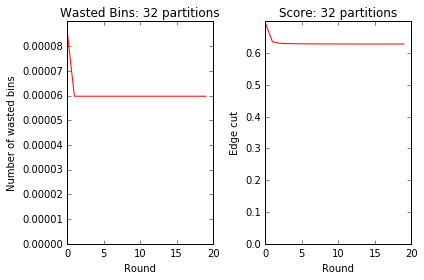

In [34]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)


40 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.702
1	5.5e-06	0.000	0.651
2	1.1e-05	0.000	0.648
3	1.6e-05	0.000	0.647
4	2.2e-05	0.000	0.647
5	2.7e-05	0.000	0.647
6	3.3e-05	0.000	0.646
7	3.8e-05	0.000	0.646
8	4.3e-05	0.000	0.646
9	4.9e-05	0.000	0.646
10	5.4e-05	0.000	0.646
11	6.0e-05	0.000	0.646
12	6.5e-05	0.000	0.646
13	7.0e-05	0.000	0.646
14	7.6e-05	0.000	0.646
CPU times: user 15.8 s, sys: 1.21 s, total: 17 s
Wall time: 16.8 s


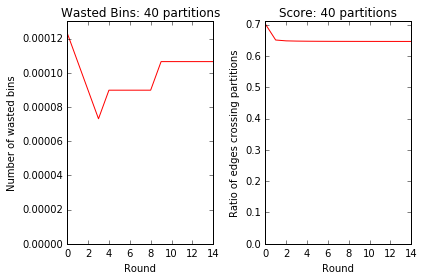

In [45]:
%time run_fennel_restreaming(edges, NUM_NODES, 40, 15)
